In [163]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from itertools import permutations 
import wandb
import sys
base = '/home3/ebrahim/isr/'
sys.path.append(base)
from RNNcell import RNN_one_layer
from run_test_trials import run_test_trials
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import pickle


In [130]:
class Regression_Trials(Dataset):

    def __init__(self, num_letters, letters_subset, list_length):

        '''
        Dataset is composed of all possible permutations of 
        the available subset of letters (s) for the specified list length (l).

        Example: If a,b, and c are the available letters, and list length is 2,
        then the dataset will be {ab, ba, ac, ca, bc, cb}.

        Length of this dataset is s! / (s-l)!. 

        @param num_letters: number of total letters (classes - 1) RNN was trained on
        @param letters_subset: subset of letters used for regression analyses 
        @param list_length: length of list for regression analyses 
        '''
        X_p = [] # store permutations 
        X_int = permutations(letters_subset, list_length)

        for p in X_int:
            X_p.append(p)

        X_int = np.stack(X_p) # shape: num_permutations x list_length 
        
        recall_cue = np.ones((X_int.shape[0], list_length+1)) * num_letters 
        self.X = torch.nn.functional.one_hot(torch.from_numpy(np.hstack((X_int, recall_cue))).to(torch.long)
        , num_classes=num_letters+1)

        end_of_list_cue = np.ones((X_int.shape[0], 1)) * num_letters
        y_int = torch.from_numpy(np.hstack((X_int, X_int, end_of_list_cue))).to(torch.long)
        self.y = torch.nn.functional.one_hot(y_int, num_classes=num_letters+1)

        self.X_reg = np.hstack((X_int, X_int)).T

    def __len__(self):

        return self.X.size(0)

    def __getitem__(self, idx):

        return self.X[idx].to(torch.float32), self.y[idx].to(torch.float32)

In [131]:
num_letters = 26
if num_letters == 10:
    letters_subset = [0, 1, 4, 7, 9]
else:
    letters_subset = [0,1,4,7,10,13,16,19,22,25]
list_length = 4
rt = Regression_Trials(num_letters, letters_subset, list_length)
rt_dataloader = DataLoader(rt, batch_size=1, shuffle=False)

In [132]:
def inverse_sigmoid(y):

    '''
    Reverses impact of sigmoid
    '''
    return torch.log(y/(1-y))



In [133]:
# load model
base = '/home3/ebrahim/isr/'
modelPATH_arr = ['feedback_onehot_26_SGD_noise_0.0_nobias', 'SGD_with_repeats_0.1',
            'SGD_with_repeats_0.2', 'SGD_with_repeats_0.3', 'small_RNN_70']

runPATH_arr = ["ebrahimfeghhi/serial_recall_RNNs/gd12r252", "ebrahimfeghhi/isr/4l18pob1", 
            "ebrahimfeghhi/isr/bsfv6vez", "ebrahimfeghhi/isr/hmo989ap", "ebrahimfeghhi/isr/loy3je5e"]

i = 0

api = wandb.Api()
run = api.run(runPATH_arr[i])
config = run.config
saved_info = torch.load(base + 'saved_models/' +  modelPATH_arr[i]  + '/model_human.pth')
model = RNN_one_layer(config['num_letters']+1, config['hs'], config['num_letters']+1, noise_std=config['noise_std'],
                        feedback_bool=True, bias=False)
model.load_state_dict(saved_info['model_state_dict'])


model_linear = RNN_one_layer(config['num_letters']+1, config['hs'], config['num_letters']+1, noise_std=config['noise_std'],
                        feedback_bool=True, bias=False, nonlin='linear')
model_linear.load_state_dict(saved_info['model_state_dict'])

config['output_size'] = 27
config['delay_start'] = 0
config['delay_middle'] = 0
config['stateful'] = False

In [134]:
device = torch.device("cuda:0")
run_test = run_test_trials(model, .5)
run_test.run_model(device, 4, config, base='/home3/ebrahim/isr/', dataloader=rt_dataloader)
h = run_test.h_stacked
h_linearized = torch.zeros_like(h)

for t, timestep in enumerate(range(h.shape[0])):
    for l, list in enumerate(range(h.shape[1])):
        h_linearized[t, l] = h[t,l]
h = h.cpu().numpy()
h_linearized = h_linearized.cpu().numpy()

In [207]:
h_encode = h[:, 0:4]
print(h_encode.shape)

(5040, 4, 200)


In [234]:
# trial 0, timestep 1, unit 0
h[0, 3, 0]

0.08229011

In [249]:
hidden_activity = np.vstack(h_encode)
print(f"Hidden activity shape {hidden_activity.shape}")
# Row i*j is th hidden activity for trial 

Hidden activity shape (20160, 200)


In [260]:
# iterating over the x axis 
if np.all(hidden_activity[1] == h[0, 1]):
    print("good")
print(hidden_activity[8,0], h[2, 0, 0])

good
0.008125055 0.008125055


In [136]:
for name, param in model.named_parameters():
    if name == 'h2o.weight':
        h2o = param.detach().cpu().numpy()
    if name == 'h2o.bias':
        h2o_bias = param.detach().cpu().numpy()
h2o_letters_subset = h2o[letters_subset]

In [137]:
# convert to time-based one hot encoding 
X = rt.X
print(X.shape)

torch.Size([5040, 9, 27])


In [146]:
time = np.arange(4)
time_one_hot = np.zeros((time.size, time.max()+1))
time_one_hot[np.arange(time.size), time] = 1
time_one_hot_trials = np.reshape(np.tile(time_one_hot, (int(X.shape[0]), 1)), (X.shape[0], 4, 4))


In [159]:
# convert to one hot encoding 
X_reg = rt.X_reg[0:4]
enc = OneHotEncoder(sparse=False)
X_transform = enc.fit_transform(X_reg.T)
X_transform_3d = np.reshape(X_transform, (X_transform.shape[0], 4, 10))
X_linear_reg_3d = np.concatenate((X_transform_3d, time_one_hot_trials),axis=2)
X_linear_reg = np.vstack(X_linear_reg_3d)

In [197]:
X_linear_reg[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [182]:
def compute_element_vectors_single_timestep(X, y, seed):

    rng = np.random.default_rng(seed)
    train_ind = rng.choice(X.shape[0], int(X.shape[0]*.9))
    test_ind = np.setdiff1d(np.arange(0,X.shape[0],1), train_ind) 

    print(X[train_ind].shape)
    print(y[train_ind].shape)

    reg = Ridge(alpha=0).fit(X[train_ind], y[train_ind])
    y_hat = reg.predict(X[test_ind])

    r2_score_value = r2_score(y[test_ind], y_hat)
    return round(r2_score_value,5), reg.coef_



In [183]:
r2, element_vectors = compute_element_vectors_single_timestep(X_linear_reg, hidden_activity, 0)
print(r2)

(18144, 14)
(18144, 200)
0.57635


In [269]:
trial_id = np.repeat(np.arange(X_reg.shape[1]), 4)
encoding_times = np.tile([1,2,3,4], X_reg.shape[1])

In [270]:
single_neuron_PD = pd.DataFrame({'encoding_times': encoding_times, 'letters': X_reg.T.ravel(), 
'firing_rate':hidden_activity[:, 0], 'trial_id':trial_id})

print(AnovaRM(data=single_neuron_PD, depvar='firing_rate', within=['encoding_times', 'letters'], subject='trial_id').fit())

In [161]:
def compute_element_vectors(X_all, y_all, num_features, timestep, seed):

    '''
    @param X_all (numpy array): shape num_permutations x (num_features x num_timesteps)
    @param y_all (numpy array): shape num_timesteps x num_permutations x num
    @param num_features (int): number of features used to encode each letters
    @param timestep (int): timestep to predict y, given X from t = 0:timestep
    @param seed (int): seed used to initalize random number generator

    Ridge regression model is fit from selected portions of X to y[timestep],
    and columns of weights correspond to element vectors. 
    '''
    if timestep != None:
        X = X_all[:, :num_features*timestep]
        y = y_all[timestep-1]
    
    rng = np.random.default_rng(seed)
    train_ind = rng.choice(X_transform.shape[0], int(X.shape[0]*.9))
    test_ind = np.setdiff1d(np.arange(0,X.shape[0],1), train_ind) 

    reg = Ridge(alpha=0).fit(X[train_ind], y[train_ind])
    y_hat = reg.predict(X[test_ind])

    r2_score_value = r2_score(y[test_ind], y_hat)
    return round(r2_score_value,5), reg.coef_

In [ ]:
compute_element_vectors(X_linear_reg, hidden_activity, 

In [29]:
def partition_W(W, num_features, MA):
    for i in range(int(W.shape[1]/num_features)):
        MA[i].append(W[:, i*num_features:(i+1)*num_features])

In [30]:
MA = []
for t in [1,2,3,4,5,6,7,8]:
    MA.append([])
    r2_score_value, W = compute_element_vectors(X_transform, h_linearized, 
                        len(letters_subset), t, seed=0)
    print("R2:", r2_score_value)
    
    if t==list_length:
        W_encoded = W

    partition_W(W, len(letters_subset), MA)

R2: 1.0
R2: 0.95181
R2: 0.91195
R2: 0.8904
R2: 0.88297
R2: 0.86404
R2: 0.81297
R2: 0.77902


In [31]:
MA_t = np.stack(MA[1])
print(MA_t.shape)

cosine_sim = np.zeros((MA_t.shape[0], MA_t.shape[2]))
for t in range(cosine_sim.shape[0]):
        for l in range(cosine_sim.shape[1]):
            cosine_sim[t,l] = np.dot(MA_t[t, :, l], h2o_letters_subset[l]
            ) / (np.linalg.norm(MA_t[t, :, l]) * np.linalg.norm(h2o_letters_subset[l]))

(7, 200, 10)


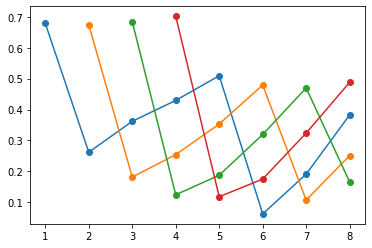

In [32]:
labels = ['1', '2', '3', '4']
for p in range(list_length):
    MA_t = np.stack(MA[p])
    cosine_sim = np.zeros((MA_t.shape[0], MA_t.shape[2]))
    for t in range(cosine_sim.shape[0]):
        for l in range(cosine_sim.shape[1]):
            cosine_sim[t,l] = np.dot(MA_t[t, :, l], h2o_letters_subset[l]
            ) / (np.linalg.norm(MA_t[t, :, l]) * np.linalg.norm(h2o_letters_subset[l]))

    plt.plot(np.arange(p+1,int(list_length*2)+1, 1), np.mean(cosine_sim, axis=1), marker='o', label=labels[p])

Text(0.5, 1.0, 'Correlation between element vectors')

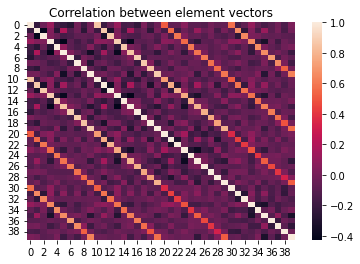

In [33]:
df = pd.DataFrame(W_encoded)
W_corr = df.corr(method='pearson')
sns.heatmap(W_corr)
plt.title("Correlation between element vectors")

In [34]:
def figure_4_code(W_encoding, ls):

    '''
    @param W_encoding: weights of linear regression model at final encoding step 
    @param ls: length of letters subset list 
    '''

    df = pd.DataFrame(W_encoding)
    W_corr = df.corr(method='pearson')
    sns.heatmap(W_corr)
    plt.title("Correlation between element vectors")
    
    c1 = []
    c2 = []
    c3 = []

    for i in range(ls):
        c1.append(W_corr.iloc[i, i+ls]) # same item one position apart
        c2.append(W_corr.iloc[i, i+2*ls]) # same item two positions apart
        c3.append(W_corr.iloc[i, i+3*ls]) # same item three positions apart

    c0_n = []
    c1_n = []
    c2_n = []
    c3_n = []

    for i in range(ls):
        for j in range(ls):
            if i == j:
                continue
            c0_n.append(W_corr.iloc[i,j]) # distinct items at same position
            c1_n.append(W_corr.iloc[i,j+ls]) # distinct items one position apart
            c2_n.append(W_corr.iloc[i,j+2*ls]) # distinct items two positions apart
            c3_n.append(W_corr.iloc[i,j+3*ls]) # distinct items three positions apart

    c_same = [c1, c2, c3]
    c_diff = [c0_n, c1_n, c2_n, c3_n]

    print("Same item positional correlations: ", np.mean(np.stack(c_same),axis=1))
    print("Distinct item positional correlations: ", np.mean(np.stack(c_diff),axis=1))

Same item positional correlations:  [0.87187959 0.56989004 0.63534821]
Distinct item positional correlations:  [-0.11095254 -0.09677726 -0.06328496 -0.07063696]


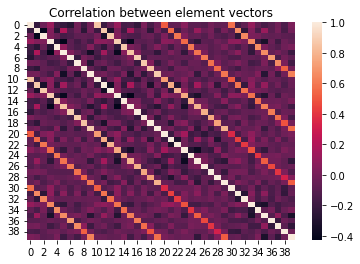

In [35]:
figure_4_code(W_encoded, ls=10)

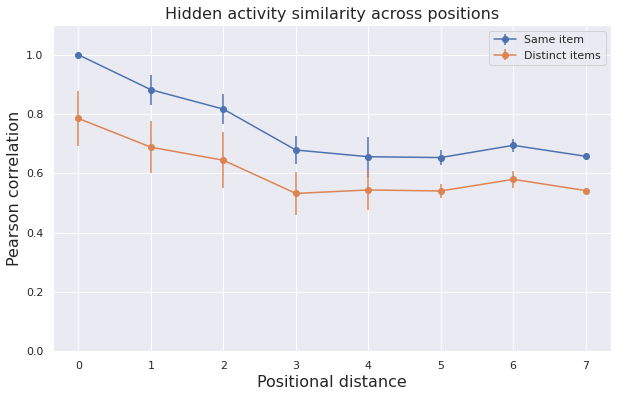

In [51]:
def positional_similarity_simple(t1, t2, X, h):

    # obtain input and hidden activity at time t1 and t2
    Xt1 = X[:, t1]
    Xt2 = X[:, t2]
    ht1 = h[t1]
    ht2 = h[t2]

    # list of length equals to number of unique letters in X
    # for every letter, stores the model representations at 
    # respective times 
    item_representations_t1 = []
    item_representations_t2 = []

    # Step 1) Obtain model representation for each item at t1 and t2
    for x in np.unique(X):

        # locate all instances where a given letter occurs at t1 and t2
        x_location_t1 = np.argwhere(Xt1 == x)
        x_location_t2 = np.argwhere(Xt2 == x)

        # average across all such representations to obtain average model representation 
        # for a given letter at a given position 
        item_representations_t1.append(np.mean(np.squeeze(ht1[x_location_t1]),axis=0))
        item_representations_t2.append(np.mean(np.squeeze(ht2[x_location_t2]),axis=0))

    corr_same = []
    corr_diff = []

    # Step 2) Compute similarity between item representations 
    for i, ht1 in enumerate(item_representations_t1):
        for j, ht2 in enumerate(item_representations_t2):
            if i == j:
                r_same, _ = pearsonr(ht1, ht2)
                corr_same.append(r_same)
            else:
                r_diff, _ = pearsonr(ht1, ht2)
                corr_diff.append(r_diff)

    return corr_same, corr_diff

def plot_pos_sim(n, start=0):

    plt.figure(figsize=(10,6))

    corr_same_avg = {}
    corr_diff_avg = {}

    for i in range(n-start):
        corr_same_avg[i] = []
        corr_diff_avg[i] = []

    for i in range(start, n):
        for j in range(start, n):
            corr_same, corr_diff = positional_similarity_simple(j,i,X_reg.T,h_linearized)
            corr_same_avg[np.abs(i-j)].append(np.mean(corr_same))
            corr_diff_avg[np.abs(i-j)].append(np.mean(corr_diff))

    avg_corr_same = {}
    std_corr_same = []
    for k,v in corr_same_avg.items():
        avg_corr_same[k] = sum(v)/ float(len(v))
        std_corr_same.append(np.std(v))
    
    avg_corr_diff = {}
    std_corr_diff = []
    for k,v in corr_diff_avg.items():
        avg_corr_diff[k] = sum(v)/ float(len(v))
        std_corr_diff.append(np.std(v))

    sns.set_theme()
    plt.title("Hidden activity similarity across positions", fontsize=16)
    plt.errorbar(avg_corr_same.keys(), avg_corr_same.values(), yerr=std_corr_same, 
    marker='o', label='Same item')
    plt.errorbar(avg_corr_diff.keys(), avg_corr_diff.values(), yerr=std_corr_diff, 
    marker='o', label='Distinct items')
    plt.xlabel("Positional distance", fontsize=16)
    plt.ylabel("Pearson correlation", fontsize=16)
    plt.ylim(0,1.1)
    plt.legend()
    plt.show()

plot_pos_sim(8)